In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Hook 제거하고 직접 구현 (torch size 안맞음)

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from transformers import (
    AutoModelForSequenceClassification,
    AutoModelForCausalLM, # SFT 모델을 이용한 응답 생성을 위해 추가
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from peft import PeftModel

# ====================================================================
# 1. 설정: 학습 때와 동일한 설정을 사용해야 합니다.
# ====================================================================

# 1. 불러올 기본 모델 ID (학습 때 사용한 모델)
base_model_id = "unsloth/llama-3.2-1b-instruct-bnb-4bit"

# 2. 저장된 LoRA 어댑터가 있는 폴더 경로
#    학습 스크립트의 'output_dir'에 지정된 경로 아래 'final_reward_adapters' 또는 마지막 체크포인트
adapter_path = "../final_reward_adapters_length_bias" # trainer.save_model()로 저장한 경로

# 응답 생성을 위한 SFT
sft_adapter_path = "../final_sft_adapters"

/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ====================================================================
# 2. 보상 모델 및 토크나이저 로딩
# ====================================================================

print("💾 기본 모델과 토크나이저를 로드합니다...")

# 4비트 양자화 설정 (학습 때와 동일)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# 기본 모델 로드 (주의: 아직 어댑터가 적용되지 않은 순수 기본 모델)
base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
    num_labels=1, # 학습 때와 동일하게 num_labels=1 설정
)

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    
# ==================== 여기부터 수정 코드를 추가합니다 ====================
print("🔄 문제가 되는 'score' 레이어를 교체하고 올바른 디바이스로 이동합니다...")

in_features = base_model.score.in_features
new_score_layer = torch.nn.Linear(
    in_features,
    1,
    bias=False,
    dtype=torch.float16 # 모델의 나머지 부분과 맞추기 위해 float16으로 직접 지정
)

# 새로 만든 레이어를 모델의 나머지 부분과 동일한 디바이스(GPU)로 이동시킵니다.
base_model.score = new_score_layer.to(base_model.device)

print("✅ 'score' 레이어 교체 및 디바이스 이동 완료!")
# ======================================================================

# --- LoRA 어댑터 적용 ---
print(f"✅ 기본 모델에 '{adapter_path}'의 어댑터를 적용합니다...")

# PeftModel.from_pretrained를 사용하여 기본 모델에 저장된 어댑터 가중치를 합칩니다.
# 이것이 최종적으로 우리가 사용할 보상 모델입니다.
reward_model = PeftModel.from_pretrained(base_model, adapter_path)

# 모델을 평가 모드로 설정합니다. (Dropout 등 비활성화)
reward_model.eval()

print("🎉 보상 모델 로딩 및 테스트 준비 완료!")

💾 기본 모델과 토크나이저를 로드합니다...


/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/transformers/quantizers/auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at unsloth/llama-3.2-1b-instruct-bnb-4bit and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔄 문제가 되는 'score' 레이어를 교체하고 올바른 디바이스로 이동합니다...
✅ 'score' 레이어 교체 및 디바이스 이동 완료!
✅ 기본 모델에 '../final_reward_adapters_length_bias'의 어댑터를 적용합니다...
🎉 보상 모델 로딩 및 테스트 준비 완료!


In [4]:
# ====================================================================
# 3. 응답 생성을 위한 SFT 모델 로드 (수정된 부분)
# ====================================================================
print("\n🔄 분석용 응답 생성을 위해 SFT 모델을 로드합니다...")
# 1. 기본 CausalLM 모델 로드
sft_base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
)
# 토크나이저는 rm_tokenizer와 동일하므로 별도 로드 필요 없음

# 2. SFT 어댑터 결합
generator_model = PeftModel.from_pretrained(sft_base_model, sft_adapter_path)
generator_model.eval()
print("🎉 SFT 모델 로딩 완료!")


🔄 분석용 응답 생성을 위해 SFT 모델을 로드합니다...


/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/transformers/quantizers/auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


🎉 SFT 모델 로딩 완료!


In [5]:
# ====================================================================
# 4. SFT 모델을 이용한 짧은 응답 / 긴 응답 생성 (수정된 부분)
# ====================================================================
print("\n🔄 SFT 모델을 이용해 짧은 응답 / 중간 응답 / 긴 응답을 생성합니다...")

# max_new_tokens를 각 호출 시 지정하기 위해 파이프라인 생성 시에는 제거합니다.
pipe = pipeline("text-generation", model=generator_model, tokenizer=tokenizer)

analysis_prompt = "Explain the concept of 'large language model' to a 5-year-old."
num_samples_each_type = 50 # 각 종류별로 50개씩, 총 150개 생성
# 그냥 나누지 말고 생성

# --- 짧은 응답 생성 ---
print(f"-> {num_samples_each_type}개의 짧은 응답 생성 중...")
short_responses_raw = pipe(
    analysis_prompt,
    num_return_sequences=num_samples_each_type,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    max_new_tokens=150  # 최대 길이를 10 토큰으로 제한하여 짧은 응답 유도
)
short_response_texts = [resp['generated_text'].split(analysis_prompt)[-1].strip() for resp in short_responses_raw]

# --- 중간 응답 생성 ---
print(f"-> {num_samples_each_type}개의 중간 응답 생성 중...")
mid_responses_raw = pipe(
    analysis_prompt,
    num_return_sequences=num_samples_each_type,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    # min_new_tokens=30,
    max_new_tokens=150
)
mid_response_texts = [resp['generated_text'].split(analysis_prompt)[-1].strip() for resp in mid_responses_raw]

# --- 긴 응답 생성 ---
print(f"-> {num_samples_each_type}개의 긴 응답 생성 중...")
long_responses_raw = pipe(
    analysis_prompt,
    num_return_sequences=num_samples_each_type,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    # min_new_tokens=90,   # 최소 길이를 80 토큰으로 보장하여 긴 응답 유도
    max_new_tokens=150 # 최대 길이를 150 토큰으로 확장
)
long_response_texts = [resp['generated_text'].split(analysis_prompt)[-1].strip() for resp in long_responses_raw]


# --- 결과 합치기 ---
response_texts = short_response_texts + mid_response_texts + long_response_texts
# 생성된 응답에 길이를 표시하는 메타데이터를 추가하면 분석이 더 용이합니다.
response_metadata = \
    [{"text": r, "length_type": "short"} for r in short_response_texts] + \
    [{"text": r, "length_type": "mid"} for r in mid_response_texts] + \
    [{"text": r, "length_type": "long"} for r in long_response_texts]

print(f"✅ 총 {len(response_texts)}개의 다양한 응답 생성 완료!")

Device set to use cuda:0



🔄 SFT 모델을 이용해 짧은 응답 / 중간 응답 / 긴 응답을 생성합니다...
-> 50개의 짧은 응답 생성 중...
-> 50개의 중간 응답 생성 중...
-> 50개의 긴 응답 생성 중...
✅ 총 150개의 다양한 응답 생성 완료!


In [6]:
response_texts

["Hey little buddy, imagine you have a very smart friend who can speak lots of languages. They can understand everything you say, and they can even talk to you like you're having a conversation. That's basically what a large language model is! It's a special computer program that can understand lots of words, meanings and things, and it can talk to people in many languages. It's like a super smart friend who can help you with your homework, tell you about the weather, or even write a story for you!",
 "Imagine you have a toy box full of different toys. You can pick up one toy at a time, and you can choose which toy to play with. Now imagine you have a million toys, and you can pick up one toy at a time, and you can choose which toy to play with. That's basically what a large language model is. It's a computer program that can learn and understand lots of different words and phrases, so that it can play with a big collection of words and phrases like a toy. It can use this big collectio

In [7]:
# ====================================================================
# 5. 새로운 보상 점수 계산 함수 (핵심 수정 사항)
# ====================================================================

def get_reward_score_and_features(model, tokenizer, prompt, response):
    """
    수동 Pooling을 포함한 새로운 보상 점수 계산 함수
    """
    text = prompt + tokenizer.eos_token + response
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        # 1. 모델을 직접 호출하며, 'output_hidden_states=True'를 전달합니다.
        #    이 한 번의 호출로 점수(logits)와 중간 피처(hidden_states)를 모두 얻습니다.
        outputs = model(**inputs, output_hidden_states=True)

        # 2. 최종 점수는 outputs.logits에서 바로 얻을 수 있습니다.
        score = outputs.logits[0].item()

        # # 3. 분석용 피처를 추출합니다.
        # #    outputs.hidden_states는 모든 레이어의 은닉 상태 튜플입니다.
        # all_hidden_states = outputs.hidden_states
        # #    튜플의 마지막 요소가 마지막 레이어의 은닉 상태 시퀀스입니다.
        # last_hidden_states = all_hidden_states[-1] # shape: [1, sequence_length, 2048]
        
        # 4. (수동 Pooling) 마지막 토큰의 은닉 상태를 선택합니다.
        # pooled_features = last_hidden_states[:, -1, :] # shape: [1, 2048]
        pooled_features = outputs.hidden_states[-1][:, -1, :].cpu().numpy()
        
        # 5. 분석을 위해 고정 크기의 피처 벡터를 저장합니다.
        # analyzed_features[response_key] = pooled_features.detach().clone()
        
    return score, pooled_features

In [8]:
print("\n🔄 각 응답에 대한 보상 점수와 피처 벡터를 추출합니다...")
analysis_data = []
for i, response in enumerate(response_texts):
    score, features = get_reward_score_and_features(reward_model, tokenizer, analysis_prompt, response)
    analysis_data.append({"response": response, "score": score, "features": features.flatten()})

df = pd.DataFrame(analysis_data)
print("✅ 추출 완료!")


🔄 각 응답에 대한 보상 점수와 피처 벡터를 추출합니다...
✅ 추출 완료!


In [9]:
df['response_length'] = df['response'].apply(lambda x: len(x.split()))
df

,response,score,features,response_length
0,"Hey little buddy, imagine you have a very smar...",-3.130859,"[-3.299, 4.516, 2.16, 1.107, 3.602, -1.508, 0....",90
1,Imagine you have a toy box full of different t...,0.498047,"[-2.668, 4.562, 2.393, -0.9805, 3.445, -2.89, ...",134
2,,-1.039062,"[4.223, -0.1954, 2.312, -2.303, 0.942, 3.943, ...",0
3,A large language model is a computer program t...,-0.560547,"[-3.387, 3.533, 2.65, 0.4663, 4.445, -3.602, 1...",84
4,Imagine you have a robot that can understand a...,1.994141,"[1.164, 6.76, 1.476, -2.49, 0.6865, -3.86, 2.4...",128
...,...,...,...,...
145,,-1.039062,"[4.223, -0.1954, 2.312, -2.303, 0.942, 3.943, ...",0
146,Imagine you are talking to a pet dog.\n\nHey p...,-1.122070,"[-2.752, 3.916, 2.734, 0.1242, 2.672, -3.436, ...",103
147,"A long time ago, computers didn't have the abi...",-2.320312,"[-1.973, 3.492, 2.043, 0.9644, 3.035, -1.763, ...",70
148,A large language model is a computer program t...,-3.583984,"[-2.674, 3.906, 1.563, 0.8687, 3.41, 0.08984, ...",61


📊 'score'와 'response_length' 간의 상관관계를 분석합니다...

--- 분석 결과 ---
점수(score)와 응답 길이(response_length) 간의 피어슨 상관계수: 0.5883
해석: 강한 양의 상관관계가 있습니다. 모델이 긴 응답에 높은 점수를 주는 경향이 매우 강합니다. (길이 편향 의심)

🎨 분석 결과를 시각화합니다...
✅ 시각화 완료! 'score_vs_length_correlation.png' 파일이 저장되었습니다.


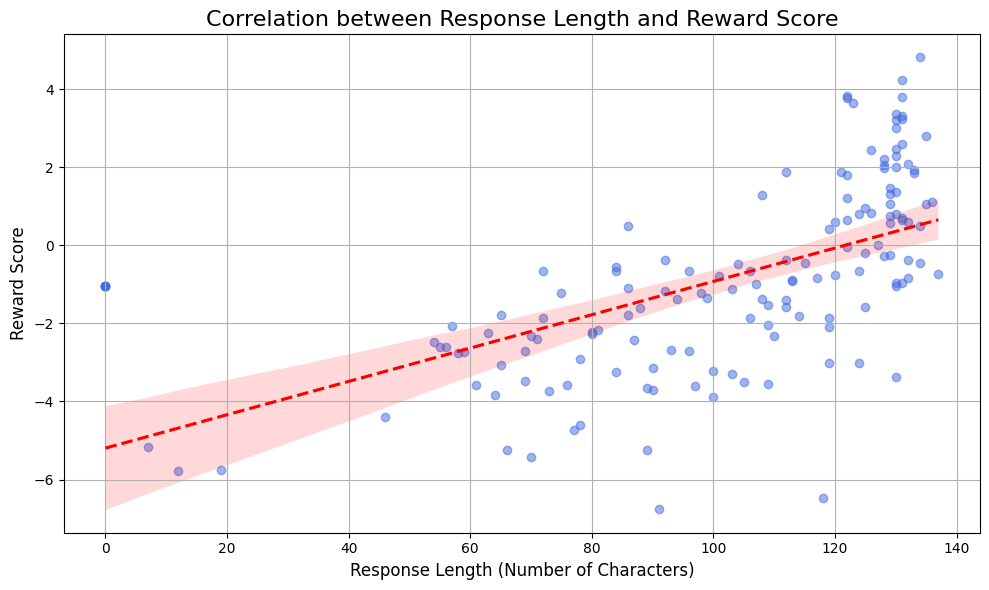

In [10]:
# --- 1. 피어슨 상관계수 계산 ---
print("📊 'score'와 'response_length' 간의 상관관계를 분석합니다...")

# .corr() 메소드를 사용하여 두 컬럼 간의 피어슨 상관계수를 계산합니다.
correlation = df['score'].corr(df['response_length'])

print("\n--- 분석 결과 ---")
print(f"점수(score)와 응답 길이(response_length) 간의 피어슨 상관계수: {correlation:.4f}")

# 상관계수 값에 대한 해석을 덧붙입니다.
if correlation > 0.5:
    print("해석: 강한 양의 상관관계가 있습니다. 모델이 긴 응답에 높은 점수를 주는 경향이 매우 강합니다. (길이 편향 의심)")
elif correlation > 0.2:
    print("해석: 약한 양의 상관관계가 있습니다. 모델이 긴 응답에 점수를 더 주는 경향이 있습니다.")
elif correlation < -0.5:
    print("해석: 강한 음의 상관관계가 있습니다. 모델이 짧은 응답에 높은 점수를 주는 경향이 매우 강합니다.")
elif correlation < -0.2:
    print("해석: 약한 음의 상관관계가 있습니다. 모델이 짧은 응답에 점수를 더 주는 경향이 있습니다.")
else:
    print("해석: 상관관계가 거의 없습니다. 모델이 응답 길이에 크게 영향을 받지 않는 것으로 보입니다.")


# --- 2. 산점도(Scatter Plot) 및 회귀선 시각화 ---

print("\n🎨 분석 결과를 시각화합니다...")

plt.figure(figsize=(10, 6))

# seaborn의 regplot을 사용하면 산점도와 회귀선을 한 번에 그릴 수 있습니다.
sns.regplot(
    data=df,
    x='response_length',
    y='score',
    scatter_kws={'alpha':0.5, 'color':'royalblue'}, # 점에 대한 스타일
    line_kws={'color':'red', 'linestyle':'--'}      # 회귀선에 대한 스타일
)

plt.title('Correlation between Response Length and Reward Score', fontsize=16)
plt.xlabel('Response Length (Number of Characters)', fontsize=12)
plt.ylabel('Reward Score', fontsize=12)
plt.grid(True)
plt.tight_layout()

# 생성된 그래프를 이미지 파일로 저장
plt.savefig("score_vs_length_correlation.png")
print("✅ 시각화 완료! 'score_vs_length_correlation.png' 파일이 저장되었습니다.")


## 분석

In [11]:
# --- 1. 'features' 컬럼을 2048개의 개별 컬럼으로 확장 ---

print("🔄 'features' 컬럼을 2048개의 개별 피처 컬럼으로 확장합니다...")

# .tolist()를 사용하면 리스트/배열로 구성된 컬럼을 효율적으로 데이터프레임으로 변환 가능
features_expanded_df = pd.DataFrame(df['features'].tolist(), index=df.index)

# 각 컬럼에 'feature_0', 'feature_1', ... 과 같이 이름을 붙여줍니다.
features_expanded_df.columns = [f'feature_{i}' for i in range(features_expanded_df.shape[1])]

# 기존 df에서 'features' 컬럼을 제외하고, 확장된 피처 df를 옆으로 붙입니다.
df_analyzable = pd.concat([df.drop('features', axis=1), features_expanded_df], axis=1)

print("✅ 피처 확장 완료! 분석용 데이터프레임 샘플:")
# 이제 각 feature가 개별 컬럼으로 들어간 것을 확인할 수 있습니다.
print(df_analyzable.head())

🔄 'features' 컬럼을 2048개의 개별 피처 컬럼으로 확장합니다...
✅ 피처 확장 완료! 분석용 데이터프레임 샘플:
                                            response     score  \
0  Hey little buddy, imagine you have a very smar... -3.130859   
1  Imagine you have a toy box full of different t...  0.498047   
2                                                    -1.039062   
3  A large language model is a computer program t... -0.560547   
4  Imagine you have a robot that can understand a...  1.994141   

   response_length  feature_0  feature_1  feature_2  feature_3  feature_4  \
0               90  -3.298828   4.515625   2.160156   1.107422   3.601562   
1              134  -2.667969   4.562500   2.392578  -0.980469   3.445312   
2                0   4.222656  -0.195435   2.312500  -2.302734   0.941895   
3               84  -3.386719   3.533203   2.650391   0.466309   4.445312   
4              128   1.164062   6.761719   1.475586  -2.490234   0.686523   

   feature_5  feature_6  ...  feature_2038  feature_2039  feature_204

/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [12]:
# --- 2. 각 피처와 보상 점수 간의 상관관계 분석 ---

print("\n📊 각 피처와 보상 점수 간의 피어슨 상관관계를 계산합니다...")

# 'score' 컬럼과 'feature_*' 컬럼들 간의 상관관계만 계산
feature_columns = [col for col in df_analyzable if col.startswith('feature_')]
correlations = df_analyzable[feature_columns].corrwith(df_analyzable['score'])
correlations = correlations.sort_values(ascending=False)

print("\n--- 상관관계 분석 결과 ---")
print("\n[보상 점수와 가장 강한 양의 상관관계를 갖는 피처 Top 10]")
print(correlations.head(10))

print("\n[보상 점수와 가장 강한 음의 상관관계를 갖는 피처 Top 10]")
print(correlations.tail(10))


📊 각 피처와 보상 점수 간의 피어슨 상관관계를 계산합니다...

--- 상관관계 분석 결과 ---

[보상 점수와 가장 강한 양의 상관관계를 갖는 피처 Top 10]
feature_1907    0.774656
feature_720     0.773220
feature_558     0.769515
feature_1031    0.760458
feature_276     0.756336
feature_1377    0.751500
feature_829     0.745484
feature_604     0.745245
feature_706     0.743934
feature_671     0.738864
dtype: float64

[보상 점수와 가장 강한 음의 상관관계를 갖는 피처 Top 10]
feature_519    -0.719461
feature_549    -0.720483
feature_1707   -0.739134
feature_663    -0.744257
feature_662    -0.747255
feature_479    -0.748145
feature_1012   -0.771246
feature_1081   -0.773904
feature_692    -0.779084
feature_1475   -0.786384
dtype: float64


/tmp/ipykernel_2477925/2969119911.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_correlations.values, y=top_correlations.index, palette="vlag")



✅ 상관관계 시각화 완료! 'reward_feature_correlation.png' 파일이 저장되었습니다.


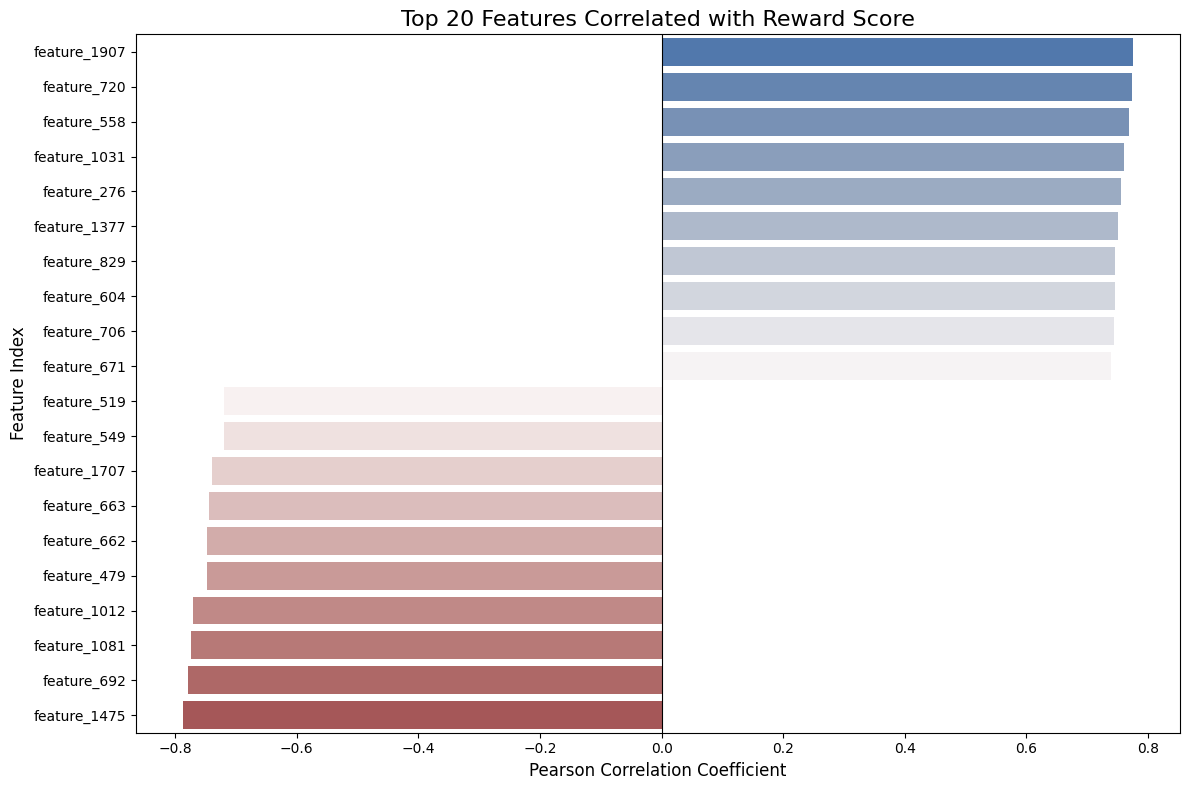

In [13]:
# --- 3. 상관관계 시각화 ---

top_n = 10
top_positive_corr = correlations.head(top_n)
top_negative_corr = correlations.tail(top_n)
top_correlations = pd.concat([top_positive_corr, top_negative_corr])

plt.figure(figsize=(12, 8))
sns.barplot(x=top_correlations.values, y=top_correlations.index, palette="vlag")
plt.title(f"Top {top_n*2} Features Correlated with Reward Score", fontsize=16)
plt.xlabel("Pearson Correlation Coefficient", fontsize=12)
plt.ylabel("Feature Index", fontsize=12)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig("reward_feature_correlation.png")
print("\n✅ 상관관계 시각화 완료! 'reward_feature_correlation.png' 파일이 저장되었습니다.")

In [14]:
# --- 4. 심층 분석: 상관관계 높은 피처와 텍스트 연결 ---
# (이전 답변과 동일한, 가장 중요한 분석 파트)

print("\n🔍 가장 상관관계가 높은 피처를 활성화시키는 텍스트를 분석합니다...")

# 가장 상관계수가 높은 피처의 이름 (예: 'feature_512')
top_feature_name = correlations.index[0]
print(f"\n가장 높은 양의 상관관계를 가진 피처: '{top_feature_name}' (상관계수: {correlations.iloc[0]:.4f})")
print("이 피처를 가장 강하게 활성화시킨 응답 Top 3:")

# 해당 피처의 값이 가장 큰 순서대로 정렬하여 상위 3개 응답 출력
top_activating_responses = df_analyzable.sort_values(by=top_feature_name, ascending=False).head(3)
for i, row in top_activating_responses.iterrows():
    print(f"  - (점수: {row['score']:.2f}) \"{row['response'][:100]}...\"")


🔍 가장 상관관계가 높은 피처를 활성화시키는 텍스트를 분석합니다...

가장 높은 양의 상관관계를 가진 피처: 'feature_1907' (상관계수: 0.7747)
이 피처를 가장 강하게 활성화시킨 응답 Top 3:
  - (점수: 1.89) "Imagine you're having a conversation with a grown-up about how computers work. 

Hey, do you know wh..."
  - (점수: 1.11) "Imagine you have a big toy box filled with lots of toys. The toys are all different sizes and shapes..."
  - (점수: 1.87) "Imagine you're talking to a computer. The computer is like a super smart friend, but it can't unders..."



     전체 상관관계 분포 요약 통계
count    2048.000000
mean        0.014559
std         0.389288
min        -0.786384
25%        -0.309485
50%         0.016790
75%         0.341153
max         0.774656
dtype: float64

🎨 상관관계 분포를 시각화합니다...
✅ 분포 시각화 완료! 'correlation_distribution.png' 파일이 저장되었습니다.


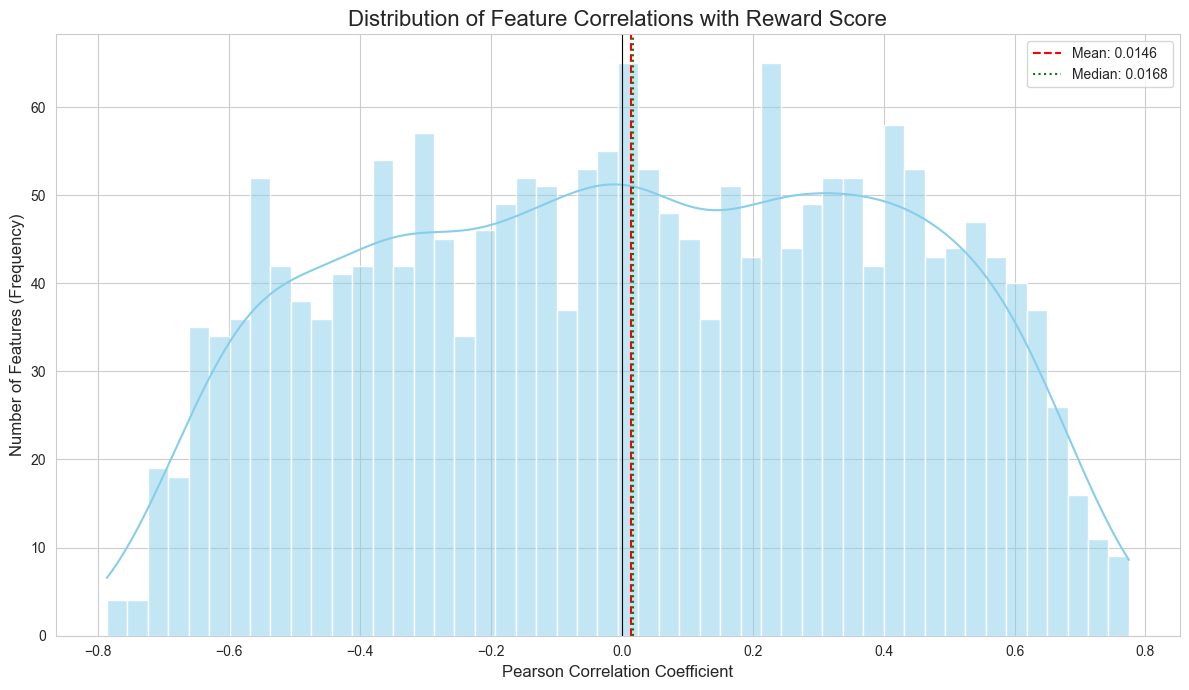

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 이전 단계에서 계산된 'correlations' 변수가 있다고 가정합니다.
# correlations = df_analyzable[feature_columns].corrwith(df_analyzable['score'])

# --- 1. 상관관계 분포에 대한 요약 통계 출력 ---

print("\n" + "="*40)
print("     전체 상관관계 분포 요약 통계")
print("="*40)
# .describe() 메소드는 개수, 평균, 표준편차, 최소값, 최대값, 사분위수를 보여줍니다.
print(correlations.describe())


# --- 2. 히스토그램 및 밀도 플롯 시각화 ---

print("\n🎨 상관관계 분포를 시각화합니다...")

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# histplot에 kde=True를 주면 히스토그램과 밀도 플롯을 함께 그립니다.
sns.histplot(correlations, kde=True, bins=50, color='skyblue')

# 분포의 평균과 중앙값을 수직선으로 표시하여 중심 경향을 파악합니다.
plt.axvline(correlations.mean(), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {correlations.mean():.4f}')
plt.axvline(correlations.median(), color='green', linestyle=':', linewidth=1.5, label=f'Median: {correlations.median():.4f}')
plt.axvline(0, color='black', linestyle='-', linewidth=0.8) # 상관계수 0을 기준으로 표시

plt.title('Distribution of Feature Correlations with Reward Score', fontsize=16)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.ylabel('Number of Features (Frequency)', fontsize=12)
plt.legend()
plt.tight_layout()

# 생성된 그래프를 이미지 파일로 저장
plt.savefig("correlation_distribution.png")
print("✅ 분포 시각화 완료! 'correlation_distribution.png' 파일이 저장되었습니다.")

## feature 방향성 분석

In [26]:
# 피처와 점수를 numpy 배열로 변환
all_features = np.vstack(df['features'].values) # shape: (num_samples, feature_dim)
all_scores = df['score'].values.reshape(-1, 1)  # shape: (num_samples, 1)

In [27]:
# 피처 공간의 주성분 찾기
pca = PCA(n_components=20) # 상위 20개 주성분 확인
principal_components = pca.fit_transform(all_features)

# 각 주성분과 보상 점수 간의 상관관계 계산
pc_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(20)])
pc_df['score'] = all_scores

correlation_with_scores = pc_df.corr()['score'].abs().sort_values(ascending=False)
print("Correlation between PCs and Score:\n", correlation_with_scores[1:]) # score 자신 제외

# 보상 점수와 가장 상관관계가 높은 주성분(PC)을 '핵심 방향'으로 선택
most_correlated_pc_index = int(correlation_with_scores.index[1].replace('PC', '')) - 1
suspicious_direction = pca.components_[most_correlated_pc_index]

# 방향 벡터 정규화 (크기를 1로 만듦)
suspicious_direction = suspicious_direction / np.linalg.norm(suspicious_direction)

print(f"\n보상 점수와 가장 연관성이 높은 방향(PC{most_correlated_pc_index + 1})을 찾았습니다.")
print("Suspicious Direction Vector (shape):", suspicious_direction.shape)

Correlation between PCs and Score:
 PC1     0.754880
PC4     0.294828
PC7     0.243897
PC3     0.228771
PC8     0.222457
PC13    0.192253
PC10    0.136825
PC9     0.135883
PC14    0.122508
PC12    0.101999
PC5     0.088890
PC2     0.087412
PC15    0.085472
PC20    0.084081
PC16    0.068127
PC18    0.042080
PC17    0.017142
PC6     0.010727
PC19    0.004793
PC11    0.000492
Name: score, dtype: float64

보상 점수와 가장 연관성이 높은 방향(PC1)을 찾았습니다.
Suspicious Direction Vector (shape): (2048,)


In [28]:
# 1. 원본 가중치 벡터 가져오기
# reward_model은 PeftModel로 로드된 최종 모델입니다.
original_weights_tensor = reward_model.score.weight.detach().clone()
original_weights = original_weights_tensor.cpu().numpy().flatten() # shape: (feature_dim,)

# 2. '의심스러운 방향'으로의 프로젝션 계산
# w_proj = (w · v) * v  (v는 방향 벡터)
projection_on_suspicious_direction = np.dot(original_weights, suspicious_direction) * suspicious_direction

# 3. 원본 가중치에서 프로젝션 성분 빼기
# alpha는 얼마나 강하게 보정할지 결정하는 하이퍼파라미터입니다 (0 ~ 1.0)
# alpha = 1.0 이면 해당 방향 성분을 완전히 제거합니다.
alpha = 0
debiased_weights = original_weights - alpha * projection_on_suspicious_direction

print("\nOriginal weights norm:", np.linalg.norm(original_weights))
print("Debiased weights norm:", np.linalg.norm(debiased_weights))


Original weights norm: 0.577
Debiased weights norm: 0.5771457590699393


In [29]:
# 1. 모델의 가중치를 새로운 가중치로 교체
with torch.no_grad():
    debiased_weights_tensor = torch.tensor(debiased_weights, dtype=original_weights_tensor.dtype).unsqueeze(0)
    reward_model.score.weight.copy_(debiased_weights_tensor.to(reward_model.device))

print("\n✅ 모델의 score 레이어 가중치를 성공적으로 수정했습니다.")

# 2. 수정된 모델로 점수를 다시 계산하고 상관관계 확인
df['new_score'] = df['features'].apply(lambda x: np.dot(x, debiased_weights))
df['response_length'] = df['response'].apply(len) # 길이 예시

print("\n상관관계 비교:")
print("Original Score vs Length:", df['score'].corr(df['response_length']))
print("New Score vs Length:     ", df['new_score'].corr(df['response_length']))


✅ 모델의 score 레이어 가중치를 성공적으로 수정했습니다.

상관관계 비교:
Original Score vs Length: 0.5729273089508632
New Score vs Length:      0.3698999347260559
